# Topic modelling
We used topic modeling to find the main topics in the articles. For the purposes of topic modeling, we used LDA (Latent Dirichlet Allocation Blei, Ng and Jordan, 2003) on the bag-of-words representation of articles. There are two main assumptions of LDA that make it a great tool for topic modeling in the sense of interpretability:
1. Documents with similar topics use similar groups of words
2. Topics of documents, which are called latent topics, can be found by searching for groups of words that frequently occur together in documents across the corpus.

And we can actually think of these two assumptions mathematically: we can say that documents are probability distributions over some underlying latent topics, and then topics themselves are probability distributions over words. So LDA represents documents as mixtures of topics that spit out words with certain probabilities.

## Methodology reference
1. Text preprocessing steps were applied:
- Lower casing
- Tokenization
- Removal of stopwords from a custom list of stopwords (smart stop list)
- Removal of punctuations ??
- Removal of numbers ??
- Lemmatization

2. Word Clouds for visualization
3. LDA for topic modeling



### 1. Filtering only rows, where there was a single issue.

7195 rows as a result

In [2]:
import pandas as pd
df_cleaned = pd.read_csv("../data/cleaned_merged_articles.csv", index_col=0).drop(columns=['representative_name', 'representative_state', 'representative_party', 'representative_committee', 'date'])
df_single_issue = df_cleaned[~df_cleaned['issue'].str.contains(';')]
df_single_issue

,issue,title,text
1,Jobs and the Economy,"""The Voice of Reason"" with Andy Hooser on KIUL...",President Biden’s budget proves to Congress an...
2,Jobs and the Economy,"""Wall Street is Having a Party"" - Rep. Soto Fl...","Washington, D.C. – U.S. Representative Darren ..."
3,Federal Budget and Taxes,"$1,500,000 to Albany and Valdosta for Infrastr...","Washington, D.C. - Today, Congressman Sanford ..."
4,Education,$1.5 million awarded for internet access for s...,Funding awarded to five local schools or distr...
5,Health Care and Social Security,$1.5M federal grant goes toward cardiac imagin...,Community Healthcare System received a $1.5 mi...
...,...,...,...
10064,Health Care and Social Security,‘It’s a crisis': Midwest lawmakers back Momnib...,"Krystal Anderson, 40, died after the stillbirt..."
10065,Health Care and Social Security,‘Methadone saved my life’ – New bill would exp...,A United States congressman from South Jersey ...
10067,"National Security, Defence, Foreign Affairs an...",‘The Department of Veterans Affairs Needs to S...,“Requesting $3 billion for an urgent 'budget s...
10069,Government and Law,“Shut it Down”- Border Dominates Zinke’s Monta...,The invasion of illegal aliens across our sout...


In [3]:
df_single_issue.groupby("issue")["text"].count()

issue
Agriculture, Energy and Environment                                1005
Constitutional Issues                                                 6
Education                                                           661
Equality and Civil Rights                                           226
Federal Budget and Taxes                                            411
Government and Law                                                  578
Health Care and Social Security                                     881
Housing                                                              14
Infrastructure and Transportation                                   443
Jobs and the Economy                                               1142
Local issues                                                        340
National Security, Defence, Foreign Affairs and Veterans issues    1433
Pro-Life/Abortion and Family Values                                   2
Science, Technology, & Telecommunications                 

For clasterization we will use the major groups with the most data:
- National Security, Defence, Foreign Affairs and Veterans issues    (1433)
- Jobs and the Economy                                               (1142)
- Agriculture, Energy and Environment                                (1005)
- Health Care and Social Security                                     (881)
- Education                                                           (661)

In [18]:
selected_issues = ["Agriculture, Energy and Environment", "National Security, Defence, Foreign Affairs and Veterans issues", "Education", "Health Care and Social Security", "Jobs and the Economy"]
df_filtered = df_single_issue[df_single_issue['issue'].isin(selected_issues)]
df_filtered.groupby("issue")["text"].count()

issue
Agriculture, Energy and Environment                                1005
Education                                                           661
Health Care and Social Security                                     881
Jobs and the Economy                                               1142
National Security, Defence, Foreign Affairs and Veterans issues    1433
Name: text, dtype: int64

In [20]:
import re
import nltk
from nltk.stem import WordNetLemmatizer

stop_words_path = "./SmartStoplist.txt"
lemmatizer = WordNetLemmatizer()


def load_stop_words():
    stop_words = []
    with open(stop_words_path, "r") as f:
        stop_words = f.read().split("\n")
    return stop_words

def preprocess_text(text: str, stopwords) -> str:
    
    text = re.sub(r"http\S+", "", text) # remove links
    text = re.sub("[^A-Za-z]+", " ", text) # remove special characters and numbers
    tokens = nltk.word_tokenize(text) # tokenization
    tokens = [lemmatizer.lemmatize(w) for w in tokens if not w.lower() in stopwords] # remove stop words + lemmatization
    text = " ".join(tokens)
    text = text.lower().strip()
    return text


stopwords = load_stop_words()
df_filtered["text"] = df_filtered["text"].apply(
    lambda text: preprocess_text(text, stopwords)
)
df_filtered = df_filtered[df_filtered["text"] != ""]

## 2. The most frequent words/ phrases for each issue and in general

In [21]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_n_phrases(doc, n=10):
    words_freq_total = []
    for n_grams in [1, 2]:
        vec = CountVectorizer(stop_words="english", ngram_range=(n_grams, 4)).fit(doc)
        bag_of_words = vec.transform(doc)
        sum_words = bag_of_words.sum(axis=0)
        words_freq = [
            (word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()
        ]
        words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:n]
        words_freq_total.extend(words_freq)
    return sorted(set(words_freq_total), key=lambda x: x[1], reverse=True)[:n]

In [22]:
selected_issues = ["Agriculture, Energy and Environment", "National Security, Defence, Foreign Affairs and Veterans issues", "Education", "Health Care and Social Security", "Jobs and the Economy"]
for issue in selected_issues:
	phrases = get_top_n_phrases(df_filtered[df_filtered["issue"]==issue]["text"], n=5)
	print(issue)
	print(phrases)
	print("---")

Agriculture, Energy and Environment
[('water', 1680), ('state', 1599), ('american', 1386), ('act', 1368), ('energy', 1367)]
---
National Security, Defence, Foreign Affairs and Veterans issues
[('veteran', 4712), ('house', 1942), ('va', 1857), ('service', 1812), ('act', 1721)]
---
Education
[('student', 2923), ('school', 2282), ('education', 1720), ('program', 1463), ('child', 1196)]
---
Health Care and Social Security
[('health', 4580), ('care', 2830), ('service', 1476), ('health care', 1446), ('act', 1442)]
---
Jobs and the Economy
[('business', 2951), ('small', 2015), ('american', 1838), ('small business', 1778), ('program', 1571)]
---


va - abbreviation for Veterans Affairs

In [23]:
get_top_n_phrases(df_filtered["text"], n=15)

[('american', 6714),
 ('health', 6632),
 ('act', 6593),
 ('state', 6508),
 ('program', 6469),
 ('rep', 5520),
 ('house', 5371),
 ('year', 5282),
 ('community', 5122),
 ('veteran', 5019),
 ('congressman', 4982),
 ('support', 4967),
 ('service', 4962),
 ('care', 4584),
 ('federal', 4176)]

In [24]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

def show_cloud(df_column, max_words=20, stopwords=STOPWORDS, title=None, suptitle=None, save_name=None, show=False):
    words = " ".join(df_column.tolist())
    wordcloud = WordCloud(
        width=500,
        height=300,
        max_words=max_words,
        background_color='white',
        stopwords=stopwords,
        random_state=42,
        collocation_threshold=10,
    ).generate(words)
    plt.figure(figsize=(10, 6), facecolor=None)
    plt.title(title)
    plt.imshow(wordcloud,interpolation="bilinear")
    plt.axis("off")
    if save_name is not None:
        plt.savefig(save_name)
    if show is True:
        plt.show()

Agriculture, Energy and Environment
[('water', np.int64(1680)), ('state', np.int64(1599)), ('american', np.int64(1386)), ('act', np.int64(1368)), ('energy', np.int64(1367))]


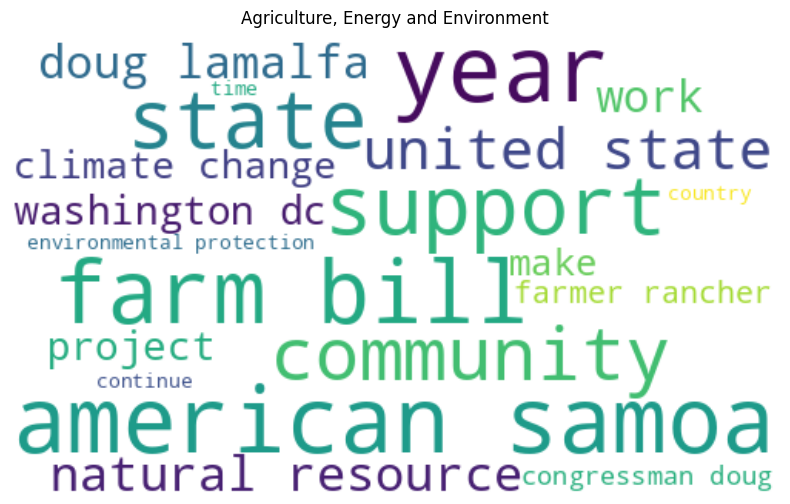

---
National Security, Defence, Foreign Affairs and Veterans issues
[('veteran', np.int64(4712)), ('house', np.int64(1942)), ('va', np.int64(1857)), ('service', np.int64(1812)), ('act', np.int64(1721))]


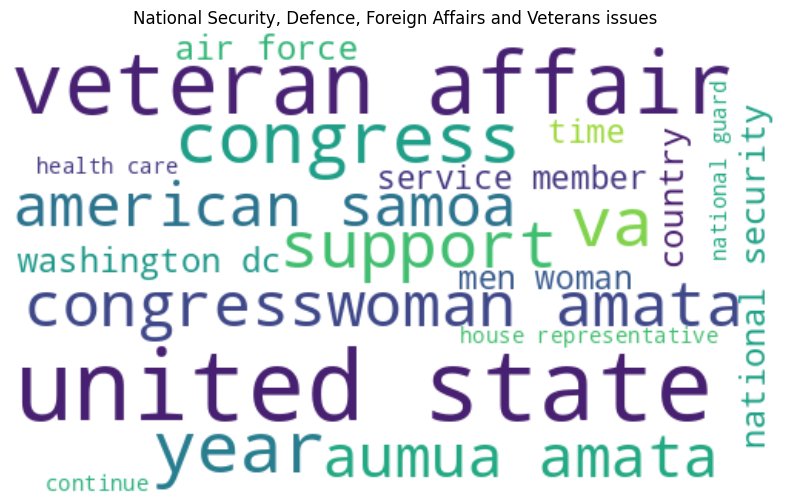

---
Education
[('student', np.int64(2923)), ('school', np.int64(2282)), ('education', np.int64(1720)), ('program', np.int64(1463)), ('child', np.int64(1196))]


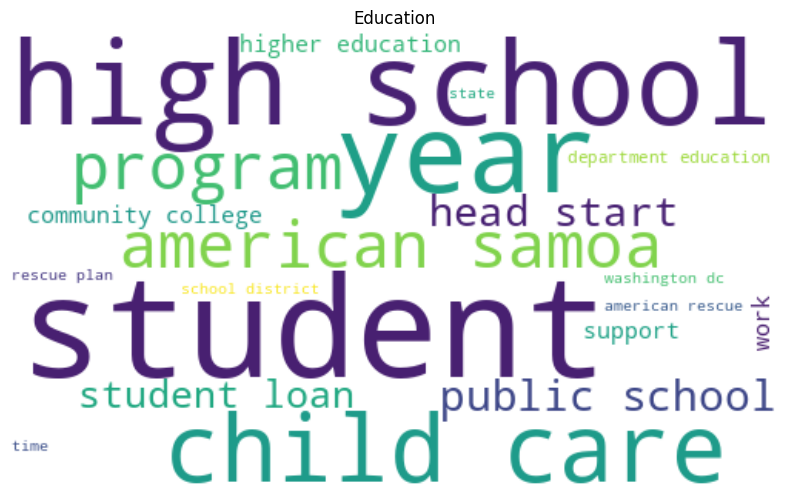

---
Health Care and Social Security
[('health', np.int64(4580)), ('care', np.int64(2830)), ('service', np.int64(1476)), ('health care', np.int64(1446)), ('act', np.int64(1442))]


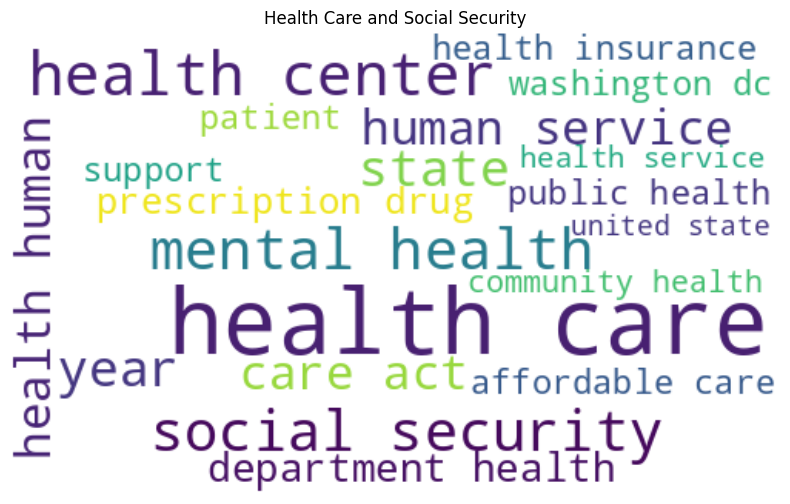

---
Jobs and the Economy
[('business', np.int64(2951)), ('small', np.int64(2015)), ('american', np.int64(1838)), ('small business', np.int64(1778)), ('program', np.int64(1571))]


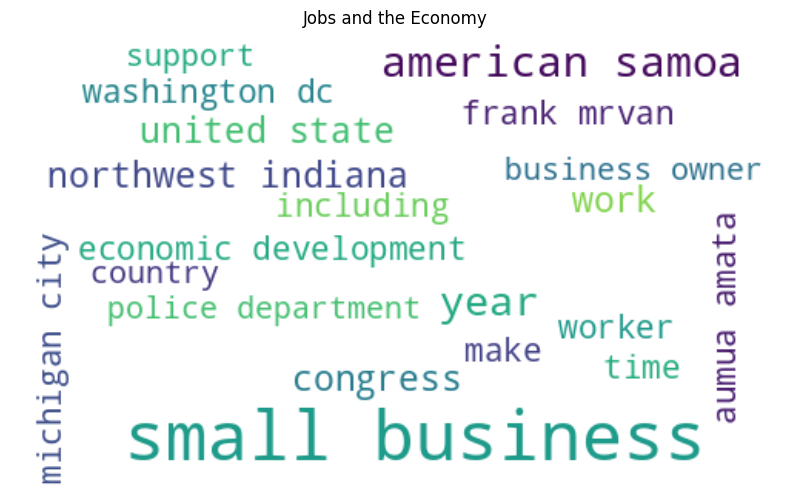

---


In [ ]:
selected_issues = ["Agriculture, Energy and Environment", "National Security, Defence, Foreign Affairs and Veterans issues", "Education", "Health Care and Social Security", "Jobs and the Economy"]
for issue in selected_issues:
	phrases = get_top_n_phrases(df_filtered[df_filtered["issue"]==issue]["text"], n=5)
	print(issue)
	print(phrases)
	issue_name = issue.replace(" ", "").replace(",", "")
	show_cloud(df_filtered[df_filtered["issue"]==issue]["text"], max_words=20, show=True, title=issue, save_name=f"word_clouds/word_cloud_{issue_name}.png")
	print("---")


## LDA

In [78]:
#LDA modeling
import gensim
from gensim import corpora
from gensim.models import LdaModel
import pyLDAvis.gensim_models

def lda_preproc(df_column):
    words = [sentence.split(" ") for sentence in df_column.tolist()]
    id2word = corpora.Dictionary(words)
    corpus = [id2word.doc2bow(text) for text in words]
    id2word.filter_extremes(no_below=0.1, no_above=0.7)
    return corpus, id2word

def lda_plot_results(corpus, id2word=None, num_topics=10, save_name=None, iterations=50, alpha='asymmetric'):
    lda = LdaModel(corpus=corpus,
                   id2word=id2word,
                   num_topics=num_topics,
                   random_state=42,
                   iterations=iterations,
                   passes=5,
                   alpha=alpha,
                   per_word_topics=False)
    lda_display = pyLDAvis.gensim_models.prepare(lda, corpus, id2word, sort_topics=False)
    if save_name is not None:
        pyLDAvis.save_html(lda_display, save_name+'.html')
    pyLDAvis.display(lda_display)
    return pyLDAvis.display(lda_display), lda

In [82]:
selected_issues = ["Agriculture, Energy and Environment", "National Security, Defence, Foreign Affairs and Veterans issues", "Jobs and the Economy"]
corpus, id2word = lda_preproc(df_filtered[df_filtered['issue'].isin(selected_issues)]["text"])
# corpus, id2word = lda_preproc(df_filtered["text"])
vis, lda = lda_plot_results(corpus=corpus, id2word=id2word, num_topics=3, save_name='LDA_results_top_3')
vis